# Breakpoint Analysis of Sylhet over the timespan 1995-2024

In [1]:
# Import packages
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pwlf
import netCDF4

### Load the ERA5 dataset (1995-2024)

In [2]:
# Load dataset
ds = xr.open_dataset('Data/instant_all.nc')

### Convert Kelvin to Celsius

In [3]:
# Convert temperature to Celsius if needed
if ds.t2m.units == 'K':
    ds['t2m'] = ds.t2m - 273.15
    ds.t2m.attrs['units'] = '°C'

### Create the month dictionary

In [4]:
t_month = {1: 'January',
           2: 'February',
           3: 'March',
           4: 'April',
           5: 'May',
           6: 'June',
           7: 'July',
           8: 'August',
           9: 'September',
           10: 'October',
           11: 'November',
           12: 'December'}

### Select the target (latitude, longitude) coordinates

In [5]:
# Sylhet (lat,lon)
target_lat = 24.9
target_lon = 91.86

### Create month selection and plotting function

In [6]:
def break_month(month):
    time = t_month[month]

    # Select the data based on the month
    ds_month = ds.sel(valid_time=ds.valid_time.dt.month == month)

    # Select the temperature and the month variables
    temp = ds_month.t2m.sel(latitude=target_lat, longitude=target_lon, method='nearest')
    sm1 = ds_month.swvl1.sel(latitude=target_lat, longitude=target_lon, method='nearest')

    # Calculate 95th percentile of temperature for extreme events
    temp_95th = np.percentile(temp, 95)

    # Create mask for extreme temperatures
    extreme_mask = temp >= temp_95th

    # Ensure that sm1 and temp are numpy arrays
    sm1_vals = sm1.values
    temp_vals = temp.values

    # Remove NaN values if any
    mask = ~np.isnan(sm1_vals) & ~np.isnan(temp_vals)
    sm1_vals = sm1_vals[mask]
    temp_vals = temp_vals[mask]
    extreme_mask = extreme_mask.values[mask]

    # Sort the data based on sm1 values
    sorted_idx = np.argsort(sm1_vals)
    sm1_sorted = sm1_vals[sorted_idx]
    temp_sorted = temp_vals[sorted_idx]
    extreme_mask_sorted = extreme_mask[sorted_idx]

    # Perform segmented regression
    my_pwlf = pwlf.PiecewiseLinFit(sm1_sorted, temp_sorted)
    breaks = 2  # Number of line segments (number of breakpoints + 1)
    res = my_pwlf.fit(breaks)

    # Predict values for plotting
    x_hat = np.linspace(sm1_sorted.min(), sm1_sorted.max(), num=100)
    y_hat = my_pwlf.predict(x_hat)

    # Create figure
    plt.figure(figsize=(10, 8))

    # Plot regular points
    plt.scatter(sm1_vals[~extreme_mask], temp_vals[~extreme_mask], c='black', alpha=0.5, label='Regular days')

    # Plot extreme temperature points
    plt.scatter(sm1_vals[extreme_mask], temp_vals[extreme_mask], c='red', alpha=0.7, label='Hot extremes')

    # Plot the segmented regression line
    plt.plot(x_hat, y_hat, 'r--', linewidth=1.5, label='Segmented regression')

    # Get R-squared value from the segmented regression
    r2 = my_pwlf.r_squared()

    # Update the statistics text
    plt.text(0.05, 0.95, f'R² = {r2:.4f}',
             transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

    # Plot breakpoints
    breakpoints = my_pwlf.fit_breaks
    for bp in breakpoints[1:-1]:  # Exclude the first and last breakpoints (min and max of x)
        plt.axvline(x=bp, color='green', linestyle='--', alpha=0.5)

    # Add labels and title
    plt.xlabel('Soil Moisture (m³/m³)')
    plt.ylabel('Maximum Temperature (°C)')
    plt.title(f'Soil Moisture vs Temperature Relationship ({time})\nSylhet', fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend()

    plt.show()

# Breakpoint for March

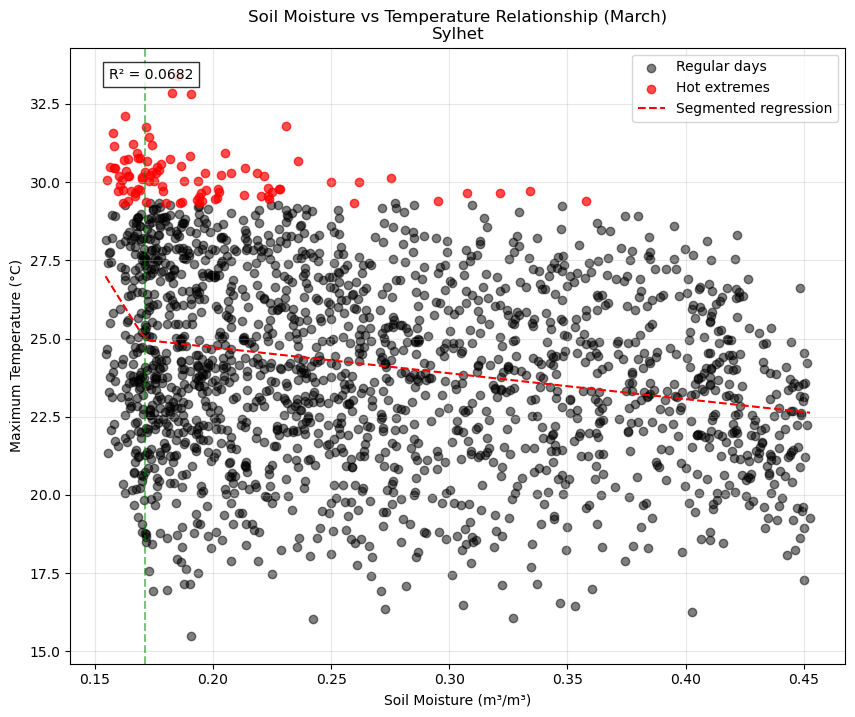

In [7]:
break_month(3)

# Breakpoint for April

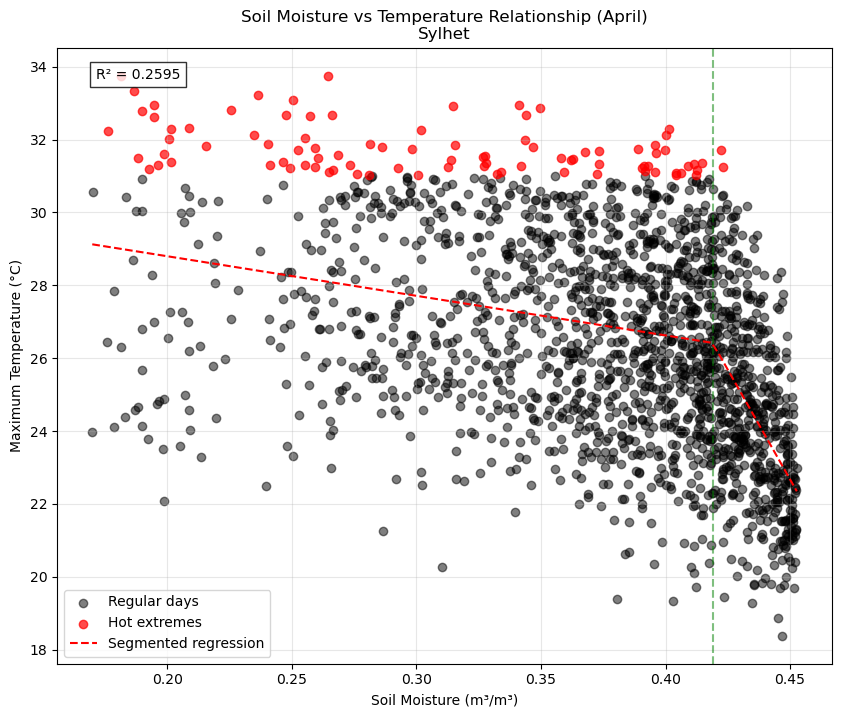

In [8]:
break_month(4)

# Breakpoint for May

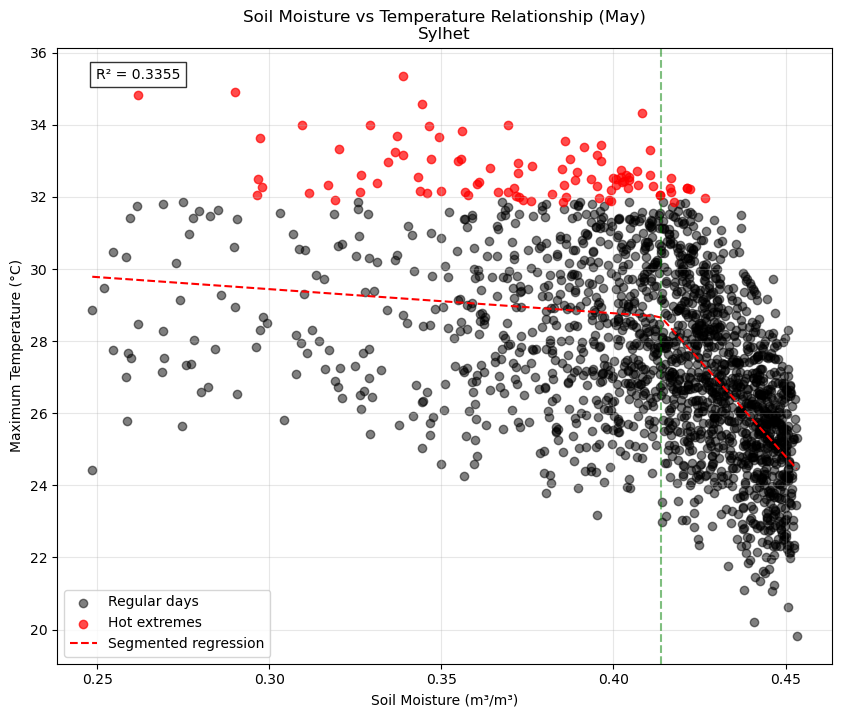

In [9]:
break_month(5)

# Breakpoint for June

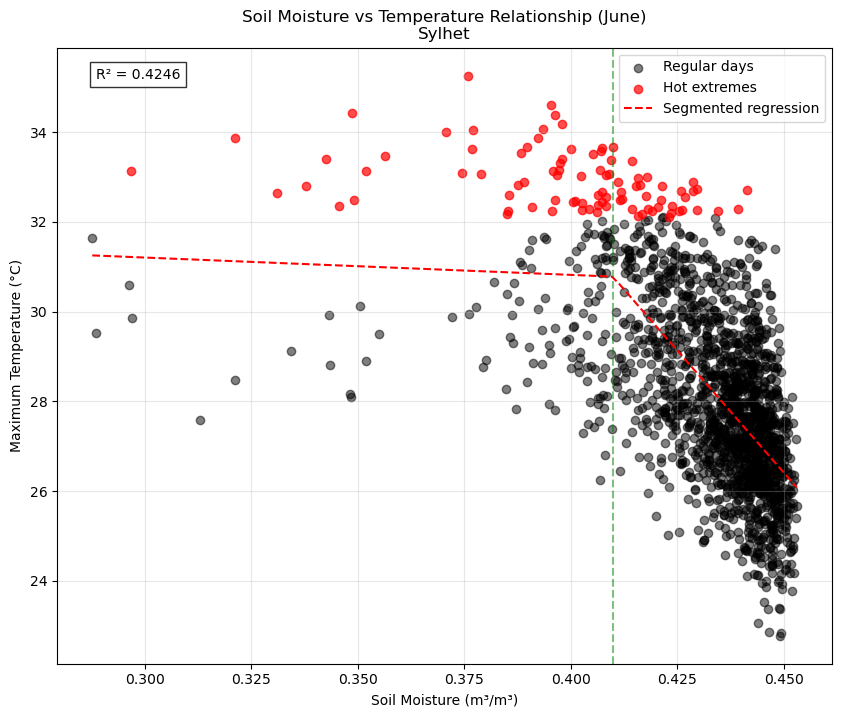

In [10]:
break_month(6)

# Breakpoint for July

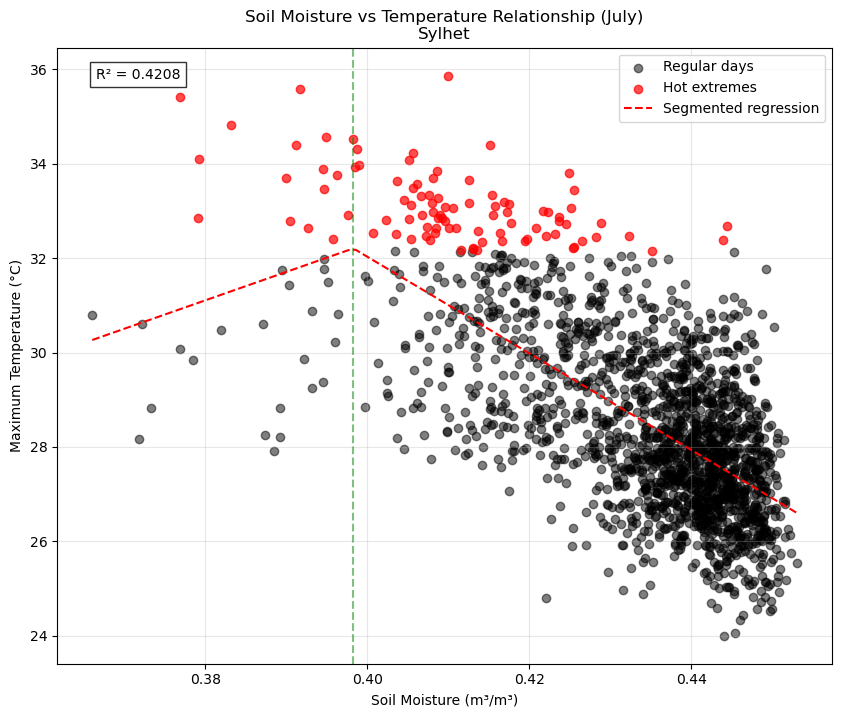

In [11]:
break_month(7)